# Calculating Mantel correlations across the host phylogeny

The purpose of this notebook is to calculate Mantel correlations between phylogenetic distance and microbiome dissimilarity at each node of the host phylogenetic tree.

The resulting significance value (and correlation coefficient) can then be plotted against the host phylogeny to visualize changes in the strength of phylosymbiosis across the host phylogeny.

## Algorithm

- preorder traverse tree
- for each node:
  - grab tips associated with node
  - filter dm to those tips
  - grab patristic dm from those tips
  - calculate mantel
  - store values on node


In [3]:
import skbio as skb
import numpy as np
import pandas as pd
import seaborn as sns
from ecopy import Mantel

from matplotlib import pyplot as plt
import pylab as pl
from qiime2 import Artifact
from skbio import TreeNode
from skbio.stats.distance import mantel
from scipy.stats import linregress
from scipy.spatial.distance import squareform, pdist
from os.path import abspath, join
from os import makedirs

## Import data

### Host Tree

In [4]:
tree_dir = abspath('../trees')
host_tree_fp = join(tree_dir, 'total_timetree_names.all.nwk.tre')
host_tree= skb.io.read(host_tree_fp, format='newick', 
                       into=TreeNode,
                       convert_underscores=False)

host_tips = [x.name for x in host_tree.tips()]

### Metadata

In [5]:
md_dir = '../metadata'
host_md_fp = join(md_dir, 'eco_md-qiime_host_species_eco_metadata_by_SampleID_gut_2.18.19.txt')
host_md = pd.read_csv(host_md_fp, sep='\t')

host_md = host_md.loc[(host_md['TimeTree_returned'].isin(host_tips))]

# filter to just tetrapods
include_classes = ['Amphibia',
                    'Mammalia',
                    'Aves',
                    'Crocodylomorpha',
                    'Lepidosauria',
                    'Chelonia']

host_md = host_md.loc[host_md['Taxonomy_Class'].isin(include_classes)]

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (34,35,83,168) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Microbial distance matrix

In [6]:
dm_dir = abspath('../bdiv')
dm_fp = join(dm_dir, 'jaccard.merged-table.in-map.nomito-nochloro.10k.qza')
dm_art = Artifact.load(dm_fp)
dm = dm_art.view(skb.DistanceMatrix)

### Filter metadata, dm, and tree to same samples and species

In [7]:
md_ids = set(host_md['SampleID'])

dm_ids = set(dm.ids)

shared_ids = dm_ids & md_ids

In [8]:
len(dm_ids)

4817

In [9]:
len(md_ids)

5684

In [10]:
len(shared_ids)

4488

Filter dm and metadata:

In [11]:
host_md = host_md.loc[host_md['SampleID'].isin(shared_ids)]
dm = dm.filter(list(shared_ids))

In [12]:
host_md.shape

(4488, 322)

In [13]:
dm.shape

(4488, 4488)

Prune tree:

In [14]:
host_tree = host_tree.shear(host_md['TimeTree_returned'])
host_tips = [x.name for x in host_tree.tips()]

## Test: overall mantel

First, we'll subset the host tree. For testing purposes, we can set subset to `True` to pull 100 random host species.

In [15]:
subset = False

In [16]:
# subset the tree if desired
if subset:
    host_subset = np.random.choice(host_tips, size=100, replace=False)
else:
    host_subset = host_tips

host_tree_subset = host_tree.shear(host_subset)

host_ids_subset = host_md.loc[host_md['TimeTree_returned'].isin(host_subset), 'SampleID']

In [17]:
len(host_ids_subset)

4488

Within-species comparisons can artificially inflate the signal of 'phylosymbiosis' because they tend to be more similar for a host of reasons, and have a branch length of 0. Since we only care about between-species comparisons, we will subset to a single arbitrarily-chosen individual per species (if `one_per_sp == True`).

In [18]:
one_per_sp = True

In [19]:
if one_per_sp:
    host_md = host_md.loc[(host_md['SampleID'].isin(host_ids_subset)) &
                          (host_md['SampleID'].isin(dm.ids)),].groupby('TimeTree_returned').first()
    host_md =  host_md.loc[(host_md['SampleID'].isin(host_ids_subset)) &
                          (host_md['SampleID'].isin(dm.ids)),].groupby('TimeTree_returned').first().reset_index()
    host_ids_subset = list(set(host_ids_subset) & set(host_md['SampleID']))

In [20]:
len(host_ids_subset)

868

### Calculate patristic distances

In [21]:
patristic_dm = host_tree_subset.tip_tip_distances()

In [22]:
patristic_dm.shape

(868, 868)

### Add diet distances

In [23]:
elton_cols = ['ET.Diet.Fruit',
             'ET.Diet.Inv',
             'ET.Diet.Nect',
             'ET.Diet.PlantO',
             'ET.Diet.Scav',
             'ET.Diet.Seed',
             'ET.Diet.Vect',
             'ET.Diet.Vend',
             'ET.Diet.Vfish',
             'ET.Diet.Vunk']

In [24]:
host_diet_df = host_md.loc[host_md[elton_cols].sum(axis=1) == 100,
                           ['SampleID'] + elton_cols].dropna()

In [25]:
host_diet_df.set_index('SampleID', inplace=True)

In [26]:
host_diet_df = host_diet_df.loc[host_ids_subset,:].dropna()

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [27]:
host_diet_df.head()

,ET.Diet.Fruit,ET.Diet.Inv,ET.Diet.Nect,ET.Diet.PlantO,ET.Diet.Scav,ET.Diet.Seed,ET.Diet.Vect,ET.Diet.Vend,ET.Diet.Vfish,ET.Diet.Vunk
SampleID,,,,,,,,,,
11166.fmnh.1059,20.0,60.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
11815.PWW.3559.FecalFTA,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11166.fmnh.2814,10.0,80.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
10684.weampp11B12,20.0,60.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0
11166.fmnh.162,0.0,10.0,0.0,20.0,0.0,70.0,0.0,0.0,0.0,0.0


In [28]:
diet_dm = skb.DistanceMatrix(squareform(pdist(host_diet_df.iloc[:, :], metric='braycurtis')))
diet_dm.ids = host_diet_df.index

In [29]:
diet_dm.shape

(788, 788)

In [30]:
rename_df = host_md.loc[host_md['SampleID'].isin(diet_dm.ids),
                             ['SampleID','TimeTree_returned']].set_index('SampleID')
rename = [rename_df.loc[x, 'TimeTree_returned'] for x in diet_dm.ids]

In [31]:
diet_dm.ids = rename

### Subset DM to remaining hosts and rename by tree

In [32]:
dm_subset = dm.filter(list(host_ids_subset))

In [33]:
dm_subset.shape

(868, 868)

In [34]:
rename_df = host_md.loc[host_md['SampleID'].isin(dm_subset.ids),
                             ['SampleID','TimeTree_returned']].set_index('SampleID')
rename = [rename_df.loc[x, 'TimeTree_returned'] for x in dm_subset.ids]

In [35]:
dm_subset.ids = rename

In [36]:
set(dm_subset.ids) == set(patristic_dm.ids)

True

# Method to run mantel iteratively across tree

In [37]:
def recursive_mantel(tree, dm1, dm2, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            corr, p, _ = mantel(dm1_s, dm2_s, **kwargs)
            node_dict[n.name] = (corr, p)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [38]:
def recursive_mantel_ecopy(tree, dm1, dm2, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            res = Mantel(dm1_s.data, dm2_s.data, **kwargs)
            
            node_dict[n.name] = (res.r_obs, res.pval)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [39]:
def recursive_partial_mantel_ecopy(tree, dm1, dm2, dmc, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            dmc_s = dmc.filter(tips)
            res = Mantel(dm1_s.data, dm2_s.data, d_condition=dmc_s.data, **kwargs)
            
            node_dict[n.name] = (res.r_obs, res.pval)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [40]:
# assign internal node names, non-integer

host_tree_subset.assign_ids()

for n in host_tree_subset.postorder():
    if n.is_tip():
        continue
    elif n.name[0].isdigit(): 
        n.name = "node%s" % n.name

In [41]:
tips = set(patristic_dm.ids) & set(dm_subset.ids) & set(diet_dm.ids)

In [42]:
len(tips)

788

Change `run` to `True` if re-calculating values

In [43]:
run = False

In [44]:
if run:
    node_dict_spearman = recursive_mantel(host_tree_subset, patristic_dm, dm_subset, method='spearman')

In [45]:
if run:
    node_dict_pearson = recursive_mantel(host_tree_subset, patristic_dm, dm_subset, method='pearson')

### Run partial Mantel tests, conditioned on diet

In [46]:
if run:
    node_dict_spearman_partial = recursive_partial_mantel_ecopy(host_tree_subset.shear(tips),
                                      patristic_dm.filter(tips),
                                      dm_subset.filter(tips),
                                      diet_dm.filter(tips),
                                      test='spearman')

In [47]:
if run:
    node_dict_pearson_partial = recursive_partial_mantel_ecopy(host_tree_subset.shear(tips),
                                      patristic_dm.filter(tips),
                                      dm_subset.filter(tips),
                                      diet_dm.filter(tips),
                                      test='pearson')

## Write to file

In [48]:
out_dir = '../phylosymbiosis/mantel'

In [49]:
makedirs(out_dir, exist_ok=True)

In [50]:
if run:
    host_tree_subset.write(join(out_dir,'annotated_host_tree.tre'), format='newick')

In [51]:
if run:
    node_df_pearson = pd.DataFrame.from_dict(node_dict_pearson, orient='index')
    node_df_pearson.columns = ['r','p']
    node_df_pearson.to_csv(join(out_dir, 'mantel.jaccard.pearson.csv'))

In [52]:
if run:
    node_df_spearman =  pd.DataFrame.from_dict(node_dict_spearman, orient='index')
    node_df_spearman.columns = ['r','p']
    node_df_spearman.to_csv(join(out_dir, 'mantel.jaccard.spearman.csv'))

In [53]:
if run:
    node_df_pearson_partial = pd.DataFrame.from_dict(node_dict_pearson_partial, orient='index')
    node_df_pearson_partial.columns = ['r','p']
    node_df_pearson_partial.to_csv(join(out_dir, 'mantel_partial.jaccard.pearson.csv'))

In [54]:
if run:
    node_df_spearman_partial =  pd.DataFrame.from_dict(node_dict_spearman_partial, orient='index')
    node_df_spearman_partial.columns = ['r','p']
    node_df_spearman_partial.to_csv(join(out_dir, 'mantel_partial.jaccard.spearman.csv'))

## Calculate values for particular nodes

In [55]:
host_tree_subset = TreeNode.read(join(out_dir,'annotated_host_tree.tre'))

In [56]:
node_df_pearson = pd.read_csv(join(out_dir, 'mantel.jaccard.pearson.csv'), index_col=0)
node_df_spearman = pd.read_csv(join(out_dir, 'mantel.jaccard.spearman.csv'), index_col=0)
node_df_pearson_partial = pd.read_csv(join(out_dir, 'mantel_partial.jaccard.pearson.csv'), index_col=0)
node_df_spearman_partial = pd.read_csv(join(out_dir, 'mantel_partial.jaccard.spearman.csv'), index_col=0)

In [66]:
def node_values(tips, tree, node_df, tree_dm, dist_dm):
    node_name = tree.lca(tips).name
    
    r = node_df_pearson.loc[node_name, 'r']
    p = node_df_pearson.loc[node_name, 'p']
    
    pats = patristic_dm.filter(tips)
    dsts = dm_subset.filter(tips)

    x = pats.to_series()
    y = dsts.to_series()

    slope, _, _, _, _ = linregress(x, y)
    
    plot = sns.lmplot('x',
                      'y',
                      pd.DataFrame({'x': x, 'y': y}).reset_index(),
                      scatter_kws={'alpha':0.1})
    plt.ylim(0.5, 1.05)

    print(("r: {r}\n"
       "p: {p}\n"
       "m: {m:8.7f}\n").format(r=r, p=p, m=slope))
    
#     plot

### Mammals

r: 0.4023749236203191
p: 0.001
m: 0.0002610



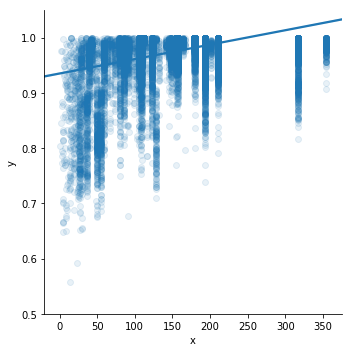

In [67]:
tips = set(host_md.loc[host_md['Taxonomy_Class'] == 'Mammalia','TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Birds

r: 0.1416411096900261
p: 0.001
m: 0.0000892



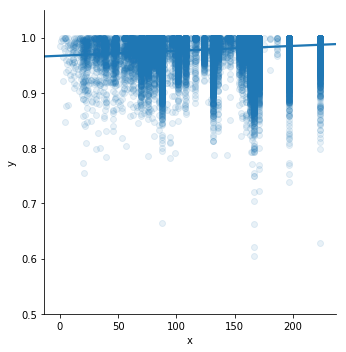

In [68]:
tips = set(host_md.loc[host_md['Taxonomy_Class'] == 'Aves','TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Bats

r: 0.0996615272451906
p: 0.032
m: 0.0001426



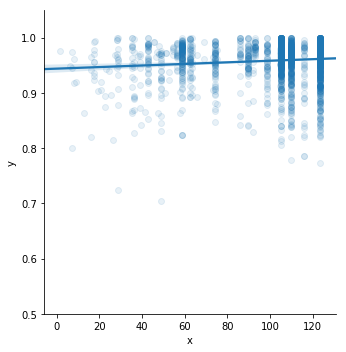

In [69]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Chiroptera',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Cetartiodactyla

r: 0.678464908738545
p: 0.001
m: 0.0016716



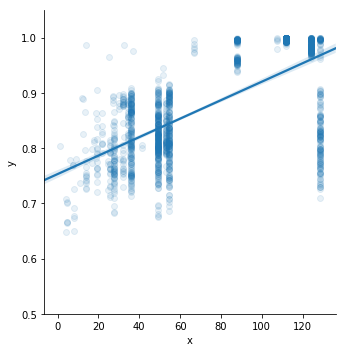

In [70]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Cetartiodactyla',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Perissodactyla

r: 0.5559052082324161
p: 0.016
m: 0.0007564



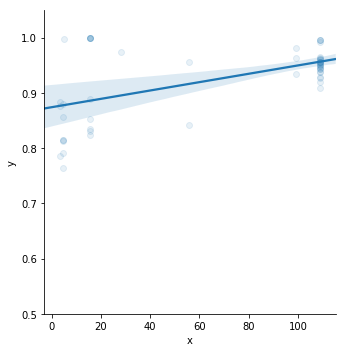

In [71]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Perissodactyla',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Primates

r: 0.4598538762562362
p: 0.001
m: 0.0005292



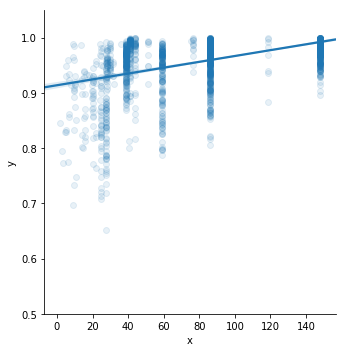

In [72]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Primates',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Carnivora

r: 0.3281452746527036
p: 0.001
m: 0.0007018



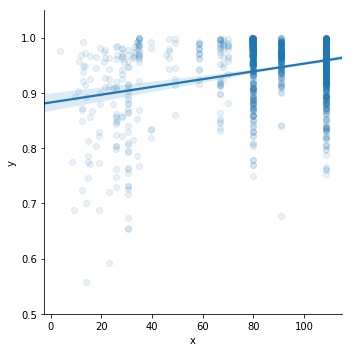

In [73]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Carnivora',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Rodentia

r: 0.28984398548612905
p: 0.001
m: 0.0001673



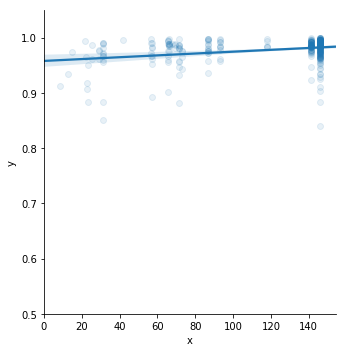

In [74]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Rodentia',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

# Write tree color file

In [107]:
itol_dir = '../phylosymbiosis/itol'

In [108]:
makedirs(itol_dir, exist_ok=True)

In [171]:
import matplotlib as mpl

In [172]:
node_df_pearson['r'].max()

0.865743525232451

In [173]:
node_df_spearman['r'].max()

0.8140991732819016

In [174]:
node_df_pearson_partial['r'].max()

0.865743525232451

In [175]:
node_df_spearman_partial['r'].max()

0.7374618389586242

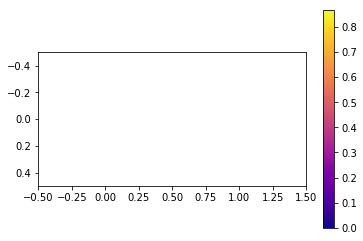

In [235]:
# create dummy invisible image
# (use the colormap you want to have on the colorbar)
cmax = node_df_pearson['r'].max()
img = plt.imshow(np.array([[0,cmax]]), cmap=mpl.cm.plasma)
img.set_visible(False)

plt.colorbar(orientation="vertical")

# add any other things you want to the figure.
# plt.plot(np.random.rand(30))

In [284]:
def colorbar(fp,
             cmax=1,
             size=(4,.7)):
    a = np.array([[0,cmax]])
    pl.figure(figsize=size)
    img = pl.imshow(a, cmap=mpl.cm.plasma)
    pl.gca().set_visible(False)
    cax = pl.axes([0.1, 0.4, 0.8, 0.5])
    pl.colorbar(orientation='horizontal', cax=cax)
    pl.savefig(fp)
    

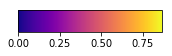

In [294]:
colorbar(join(itol_dir, 'mantel.jaccard.pearson.itol-r_colorbar.pdf'),
         cmax=node_df_pearson['r'].max(),
         size=(2.5,.6))

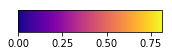

In [298]:
colorbar(join(itol_dir, 'mantel.jaccard.spearman.itol-r_colorbar.pdf'),
         cmax=node_df_spearman['r'].max(),
         size=(2.5,.6))

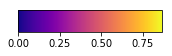

In [297]:
colorbar(join(itol_dir, 'mantel_partial.jaccard.pearson.itol-r_colorbar.pdf'),
         cmax=node_df_pearson_partial['r'].max(),
         size=(2.5,.6))

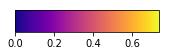

In [299]:
colorbar(join(itol_dir, 'mantel_partial.jaccard.spearman.itol-r_colorbar.pdf'),
         cmax=node_df_spearman_partial['r'].max(),
         size=(2.5,.6))

In [176]:
def get_colors(vals, col, cmap=mpl.cm.plasma):
    norm = mpl.colors.Normalize(vmin=0, vmax=np.max(vals))
    
    colors = []
    
    for i in vals:
        rgb = mpl.cm.ScalarMappable(norm=norm,
                                    cmap=cmap).to_rgba(i)
        hex_val = mpl.colors.rgb2hex(rgb)
        colors.append(hex_val)

    return(colors)

def write_itol_colors(node_df, col, fp, label='branch_colors'):
    out = ('DATASET_STYLE\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #ffff00\n\n'
           'DATASET_LABEL %s\n\n'
           'DATA\n'
           '#NODE_ID TYPE COLOR LABEL_OR_STYLE SIZE_FACTOR\n' % label)

    for i, row in node_df.iterrows():
        out += '{0} branch node {1} 2 normal\n'.format(i, row[col])

    with open(fp, 'w') as f:
        f.write(out)

In [ ]:
#LEGEND_TITLE,Dataset legend
#LEGEND_SHAPES,1,2,3
#LEGEND_COLORS,#ff0000,#00ff00,#0000ff
#LEGEND_LABELS,value1,value2,value3

In [86]:
node_df_pearson['r_color'] = get_colors(node_df_pearson['r'], col='r')
node_df_spearman['r_color'] = get_colors(node_df_spearman['r'], col='r')

In [87]:
node_df_pearson_partial['r_color'] = get_colors(node_df_pearson_partial['r'], col='r')
node_df_spearman_partial['r_color'] = get_colors(node_df_spearman_partial['r'], col='r')

In [88]:
write_itol_colors(node_df_pearson, 
                  'r_color', 
                  join(itol_dir, 'mantel.jaccard.pearson.itol-r_colors.txt'),
                  label='pearson_r')
write_itol_colors(node_df_spearman, 
                  'r_color',
                  join(itol_dir, 'mantel.jaccard.spearman.itol-r_colors.txt'),
                  label='spearman_r')


In [89]:
write_itol_colors(node_df_pearson_partial, 
                  'r_color', 
                  join(itol_dir, 'mantel_partial.jaccard.pearson.itol-r_colors.txt'),
                  label='pearson_r_partial')
write_itol_colors(node_df_spearman_partial, 
                  'r_color',
                  join(itol_dir, 'mantel_partial.jaccard.spearman.itol-r_colors.txt'),
                  label='spearman_r_partial')

### Write pie chart p-val indicator file

In [90]:
# 9132,0,50,11000
def write_pval_pies(node_df, col, fp, label='p-vals', breaks = [0.001, 0.01, 0.05]):
    header = ("DATASET_PIECHART\n"
              "SEPARATOR SPACE\n"
              "DATASET_LABEL %s\n"
              "COLOR #ff0000\n"
              "FIELD_COLORS #ff0000\n"
              "FIELD_LABELS p-value\n"
              "MAXIMUM_SIZE 30\n"
              "BORDER_WIDTH 0\n"
              "DATA\n" % label)
    
    break_sizes = [int(30 - i/len(breaks)*30) for i, x in enumerate(breaks)]
    pies = []
    for i, row in node_df.iterrows():
        size = 0
        for s, b in enumerate(breaks):
            if row[col] > b:
                continue
            else:
                size = break_sizes[s]
                break
        if size > 0:
            pies.append("{0} 0 {1} 1".format(i, size))
    
    out = header + '\n'.join(pies)
    
    with open(fp, 'w') as f:
        f.write(out)
            

In [91]:
write_pval_pies(node_df_pearson, 
                'p', 
                join(itol_dir, 'mantel.jaccard.pearson.itol-p_pies.txt'), 
                label='pearson_p')
write_pval_pies(node_df_spearman, 
                'p', 
                join(itol_dir, 'mantel.jaccard.spearman.itol-p_pies.txt'),
                label='spearman_p')

In [92]:
write_pval_pies(node_df_pearson_partial, 
                'p',
                join(itol_dir, 'mantel_partial.jaccard.pearson.itol-p_pies.txt'),
                label='pearson_p_partial')
write_pval_pies(node_df_spearman_partial, 
                'p',
                join(itol_dir, 'mantel_partial.jaccard.spearman.itol-p_pies.txt'),
                label='spearman_p_partial')

### Write clade highlighting

    

In [183]:
def write_clade_highlights(md_df, tree, tax_col, tree_col, fp,
                           label='clade_highlights',
                           colors=None, alpha=0.4, cmap=mpl.cm.Set3):
    out = ('DATASET_COLORSTRIP\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #b2df8a\n\n'
           'DATASET_LABEL %s\n\n'% label)
    
    taxa = md_df[tax_col].unique()
    
    if colors is None:
        clist = cmap(range(len(taxa)), alpha=alpha)
        rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                          int(x[1]*255),
                                          int(x[2]*255),
                                          x[3]) for x in clist]
        colors = {x: rgblist[i] for i, x in enumerate(taxa)}
    
    legend_shapes = ' '.join(['1']*len(taxa))
    legend_colors = ''
    legend_labels = ''
    
    for x in colors:
        legend_colors += ' %s' % colors[x]
        legend_labels += ' %s' % x
    
    out += ('LEGEND_TITLE host_colors\n'
            'LEGEND_SHAPES {0}\n'
            'LEGEND_COLORS{1}\n'
            'LEGEND_LABELS{2}\n\nDATA\n').format(legend_shapes,
                                            legend_colors,
                                            legend_labels)
        
    for taxon in taxa:
        tips = set(md_df.loc[md_df[tax_col] == taxon, tree_col])
        node = tree.lowest_common_ancestor(tips)
        
        out += "{0} {1}\n".format(node.name, colors[taxon])
#         out += "{0} range {1} {2}\n".format(node.name, colors[taxon], taxon)
        
    with open(fp, 'w') as f:
        f.write(out)


In [232]:
class_colors = {'Amphibia': '#b2df8a',
                 'Chelonia': '#33a02c',
                 'Lepidosauria': '#fb9a99',
                 'Crocodylomorpha': '#e31a1c',
                 'Aves': '#EACB47',
                 'Mammalia': '#6a3d9a'}

write_clade_highlights(host_md, 
                       host_tree_subset, 
                       'Taxonomy_Class', 
                       'TimeTree_returned',
                       join(itol_dir, 'mantel.itol-Class_colors.txt'),
                       colors=class_colors)

In [233]:
!head -n 20 ../phylosymbiosis/itol/mantel.itol-Class_colors.txt

DATASET_COLORSTRIP

SEPARATOR SPACE

COLOR #b2df8a

DATASET_LABEL clade_highlights

LEGEND_TITLE host_colors
LEGEND_SHAPES 1 1 1 1 1 1
LEGEND_COLORS #b2df8a #33a02c #fb9a99 #e31a1c #EACB47 #6a3d9a
LEGEND_LABELS Amphibia Chelonia Lepidosauria Crocodylomorpha Aves Mammalia

DATA
node1659 #EACB47
node2688 #6a3d9a
node1688 #33a02c
node1655 #e31a1c
node56 #b2df8a
node139 #fb9a99


### Write flight annotations

In [222]:
def write_binary_colorstrip(md_df, col, tree_col, fp,
                           label='categorical_colorstrip',
                           colors=None, alpha=1, cmap=mpl.cm.Set3):
    out = ('DATASET_COLORSTRIP\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #8ab2df\n\n'
           'DATASET_LABEL %s\n\n'% label)
    
    values = md_df[col].unique()
    
    if colors is None:
        clist = cmap(range(len(values)), alpha=alpha)
        rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                          int(x[1]*255),
                                          int(x[2]*255),
                                          x[3]) for x in clist]
        colors = {x: rgblist[i] for i, x in enumerate(values)}
    
    legend_shapes = ' '.join(['1']*len(values))
    legend_colors = ''
    legend_labels = ''
    
    for x in colors:
        legend_colors += ' %s' % colors[x]
        legend_labels += ' %s' % x
    
    out += ('LEGEND_TITLE {0}\n'
            'LEGEND_SHAPES {1}\n'
            'LEGEND_COLORS{2}\n'
            'LEGEND_LABELS{3}\n\nDATA\n').format(label,
                                            legend_shapes,
                                            legend_colors,
                                            legend_labels)
        
    for taxon in md_df[tree_col]:
        
        out += "{0} {1}\n".format(taxon, colors[md_df.loc[md_df[tree_col] == taxon,
                                                          col].values[0]])
    
    with open(fp, 'w') as f:
        f.write(out)



In [224]:
flight_colors = {'flighted': '#000000',
                 'flightless': '#FFFFFF'}

write_binary_colorstrip(host_md, 
                        'flight_status', 
                        'TimeTree_returned', 
                        join(itol_dir, 'mantel.itol-flight_colors.txt'),
                        colors=flight_colors)

### Write diet barcharts

In [96]:
def get_qualitative_colors(fields, cmap=mpl.cm.Set3, alpha=0.4):
    clist = cmap(range(len(taxa)), alpha=alpha)
    rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                      int(x[1]*255),
                                      int(x[2]*255),
                                      x[3]) for x in clist]
    return(rgblist)

def format_iTOL_multibar(fields, md, 
                         tree_ref_col=None, 
                         field_colors=None, 
                         field_labels=None, 
                         dataset_label='Multibar Chart', 
                         dataset_color=None, 
                         legend=True, 
                         unstacked=False,
                         width=1000, 
                         margin=0,
                         alpha=0.8,
                        ):
    """
    fields: array of columns titles in [metadata] to chart
    metadata: pd.df containing samples to graph and data
    """
    
    if field_labels is None:
        field_labels=fields
    
    if field_colors is None:
        field_colors=get_qualitative_colors(fields, alpha=alpha)
    
    if tree_ref_col is None:
        tree_ref_col=metadata.columns[0]

    if dataset_color is None:
        dataset_color = "#00FF00"

    # remove nans
    metadata = md.loc[:,fields + [tree_ref_col]].dropna()
    
    outstring = ''
    
    outstring += 'DATASET_MULTIBAR\n'
    outstring += 'SEPARATOR TAB\n'
    outstring += 'DATASET_LABEL\t%s\n' % dataset_label
    outstring += 'COLOR\t%s\n' % dataset_color
    outstring += 'FIELD_COLORS\t%s\n' % '\t'.join(field_colors)
    outstring += 'FIELD_LABELS\t%s\n' % '\t'.join(field_labels)    
    
    if legend:
        outstring += 'LEGEND_TITLE\tDataset legend\n'
        outstring += 'LEGEND_SHAPES\t%s\n' % '\t'.join(['1']*len(fields))
        outstring += 'LEGEND_COLORS\t%s\n' % '\t'.join(field_colors)
        outstring += 'LEGEND_LABELS\t%s\n' % '\t'.join(field_labels)
    
    outstring += 'MARGIN\t%s\n' % margin
    outstring += 'WIDTH\t%s\n' % width

    if unstacked:
        outstring += 'ALIGN_FIELDS\t1\n'
        
    outstring += 'DATA\n'
    for index, row in metadata.iterrows():
        outstring += row[tree_ref_col].replace(' ', '_') + '\t%s\n' % '\t'.join([str(row[x]) for x in fields])

    return(outstring)


In [97]:
fields = ['ET.Diet.Fruit',
 'ET.Diet.Inv',
 'ET.Diet.Nect',
 'ET.Diet.PlantO',
 'ET.Diet.Scav',
 'ET.Diet.Seed',
 'ET.Diet.Vect',
 'ET.Diet.Vend',
 'ET.Diet.Vfish',
 'ET.Diet.Vunk']

bar = format_iTOL_multibar(fields, 
                     host_md, 
                     tree_ref_col='TimeTree_name', 
                     field_colors=['#a6cee3',
                                   '#cab2d6',
                                   '#1f78b4',
                                   '#33a02c',
                                   '#6a3d9a',
                                   '#b2df8a',
                                   '#fb9a99',
                                   '#e31a1c',
                                   '#ff7f00',
                                   '#fdbf6f'], 
                     field_labels=['Fruit',
                                   'Invertebrates',
                                   'Nectar',
                                   'Plants',
                                   'Scavenging',
                                   'Seeds',
                                   'Meat (Ectotherms)',
                                   'Meat (Endotherms)',
                                   'Meat (Fish)',
                                   'Meat (Unknown)'], 
                     dataset_label='Diet Barchart', 
                     dataset_color=None, 
                     legend=True,
                     width=200, 
                     alpha=1.0)

with open(join(itol_dir, 'mantel.itol-diet_bar.txt'), 'w') as f:
    f.write(bar)

In [98]:
!head -n 20 ../phylosymbiosis/itol/mantel.itol-diet_bar.txt

DATASET_MULTIBAR
SEPARATOR TAB
DATASET_LABEL	Diet Barchart
COLOR	#00FF00
FIELD_COLORS	#a6cee3	#cab2d6	#1f78b4	#33a02c	#6a3d9a	#b2df8a	#fb9a99	#e31a1c	#ff7f00	#fdbf6f
FIELD_LABELS	Fruit	Invertebrates	Nectar	Plants	Scavenging	Seeds	Meat (Ectotherms)	Meat (Endotherms)	Meat (Fish)	Meat (Unknown)
LEGEND_TITLE	Dataset legend
LEGEND_SHAPES	1	1	1	1	1	1	1	1	1	1
LEGEND_COLORS	#a6cee3	#cab2d6	#1f78b4	#33a02c	#6a3d9a	#b2df8a	#fb9a99	#e31a1c	#ff7f00	#fdbf6f
LEGEND_LABELS	Fruit	Invertebrates	Nectar	Plants	Scavenging	Seeds	Meat (Ectotherms)	Meat (Endotherms)	Meat (Fish)	Meat (Unknown)
MARGIN	0
WIDTH	200
DATA
Accipiter_cooperii	0.0	0.0	0.0	0.0	0.0	0.0	10.0	90.0	0.0	0.0
Accipiter_striatus	0.0	0.0	0.0	0.0	0.0	0.0	0.0	100.0	0.0	0.0
Accipiter_tachiro	0.0	10.0	0.0	0.0	0.0	0.0	20.0	70.0	0.0	0.0
Accipiter_trivirgatus	0.0	20.0	0.0	0.0	0.0	0.0	20.0	60.0	0.0	0.0
Aceros_corrugatus	90.0	10.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
Acinonyx_jubatus	0.0	0.0	0.0	0.0	0.0	0.0	0.0	100.0	0.0	0.0
Acrocephalus_arundinaceus	10.0	7